# --- Machine Learning Project: Car Price Prediction - US Market Analysis ---

#--- Project Overview ---
This project aims to help a Chinese automobile company understand the factors affecting car prices in the American market. By building multiple regression models, we identify significant variables such as engine size and curb weight that accurately predict car prices, providing a data-driven approach for market entry strategy.

#--- 1. Loading and Preprocessing ---

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
#Load the dataset
df = pd.read_csv('CarPrice_Assignment.csv')
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [3]:
#Feature Engineering
#The 'CarName' contains both brand and model. We extract the brand (first word).
df['CompanyName'] = df['CarName'].apply(lambda x: x.split(' ')[0].lower())


In [4]:
#Data Cleaning
#Fixing inconsistent brand names identified during initial exploration
df['CompanyName'] = df['CompanyName'].replace({
    'maxda': 'mazda',
    'porcshce': 'porsche',
    'toyouta': 'toyota',
    'vokswagen': 'volkswagen',
    'vw': 'volkswagen'
})

In [5]:
#Feature Selection
#'car_ID' is just an index and 'CarName' is now redundant after extracting 'CompanyName'
X = df.drop(columns=['car_ID', 'CarName', 'price'])
y = df['price']


In [6]:
#Data Splitting
#spliting the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
#Preprocessing Definition
#Categorical columns need One-Hot Encoding, Numerical columns need Scaling
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

print(f"Data Loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Features: {X.shape[1]} (Categorical: {len(categorical_cols)}, Numerical: {len(numerical_cols)})")

Data Loaded: 205 rows, 27 columns
Features: 24 (Categorical: 10, Numerical: 14)


###Brand Cleaning:
Extracted brand names to reduce high cardinality in the CarName column and fixed spelling mistakes (e.g., 'vokswagen' to 'volkswagen').

###Dropping Identifiers:
Removed car_ID to prevent the model from memorizing row order.

###Encoding Preparation:
Identified categorical features (like carbody and fueltype) for One-Hot Encoding.

###Scaling Preparation:
Set up StandardScaler for numerical features to ensure that variables with large ranges (like peakrpm) do not dominate variables with small ranges (like boreratio).

#--- 2. Model Implementation ---

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

In [9]:
# Define a dictionary to store our models for easy iteration
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Regressor": SVR(kernel='linear')
}

In [10]:
# A dictionary to store the trained pipelines and their predictions
trained_pipelines = {}
predictions = {}

# --- Implementation Loop ---
for name, model in models.items():
    # Create a pipeline: 1. Preprocess data -> 2. Apply the Regressor
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Fit the model on training data
    pipeline.fit(X_train, y_train)

    # Store the trained pipeline
    trained_pipelines[name] = pipeline

    # Generate predictions on the test set
    predictions[name] = pipeline.predict(X_test)

    print(f"Model Implemented: {name}")

Model Implemented: Linear Regression
Model Implemented: Decision Tree
Model Implemented: Random Forest
Model Implemented: Gradient Boosting
Model Implemented: Support Vector Regressor


In [11]:
# Example: Displaying the first 5 predictions of the Random Forest model
print("\nSample Random Forest Predictions:")
print(predictions["Random Forest"][:5])


Sample Random Forest Predictions:
[36048.27       19240.75        8986.23       13323.45416667
 27182.455     ]


###Linear Regression:
A baseline model that assumes a linear relationship between the independent variables and the car price.

###Decision Tree Regressor:
A non-linear model that splits the data into branches based on feature values to reach a prediction.

###Random Forest Regressor:
An ensemble method that trains multiple decision trees and averages their results to improve accuracy and control overfitting.

###Gradient Boosting Regressor:
An ensemble technique that builds trees sequentially, where each new tree attempts to correct the errors of the previous ones.

###Support Vector Regressor (SVR):
A model that tries to find a hyperplane in a high-dimensional space that fits the data points within a certain threshold (epsilon).

#--- 3. Model Evaluation ---

###R-squared ($R^2$):
Measures how well the independent variables explain the variance in the car price. (Closer to $1.0$ is better).

###Mean Squared Error (MSE):
The average of the squared differences between predicted and actual prices.

###Mean Absolute Error (MAE):
The average of the absolute differences between predicted and actual prices (more interpretable in dollar terms).

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
#Calculate Evaluation Metrics
results = []

#trained_pipelines is the dictionary of models fitted in the previous step
for name, pipeline in trained_pipelines.items():
    # Predict on test data
    y_pred = pipeline.predict(X_test)

    # Calculate Metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "MAE": mae,
        "MSE": mse,
        "R-squared": r2
    })

In [14]:
#Create Comparison Table
comparison_df = pd.DataFrame(results).sort_values(by="R-squared", ascending=False)
print("--- Model Performance Comparison Table ---")
print(comparison_df)

--- Model Performance Comparison Table ---
                      Model          MAE           MSE  R-squared
2             Random Forest  1309.436415  3.416608e+06   0.956721
3         Gradient Boosting  1666.639761  5.684860e+06   0.927989
1             Decision Tree  1785.776415  7.396941e+06   0.906301
0         Linear Regression  1807.703987  7.808716e+06   0.901085
4  Support Vector Regressor  4893.043061  7.139420e+07   0.095635


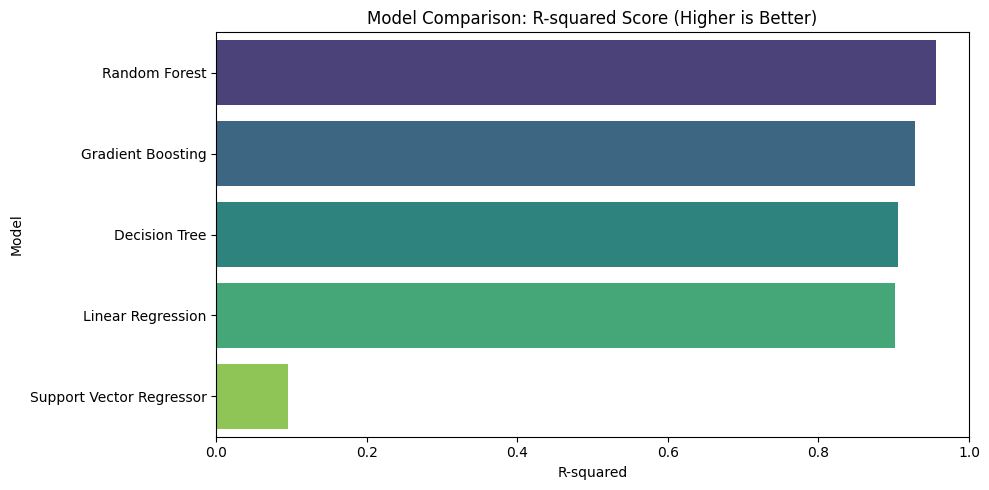

In [15]:
#Visualisations

# A. R-squared Comparison Plot
plt.figure(figsize=(10, 5))
plot_r2_df = comparison_df[comparison_df['R-squared'] > -1]
sns.barplot(data=plot_r2_df, x='R-squared', y='Model', hue='Model', palette='viridis', legend=False)
plt.title('Model Comparison: R-squared Score (Higher is Better)')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


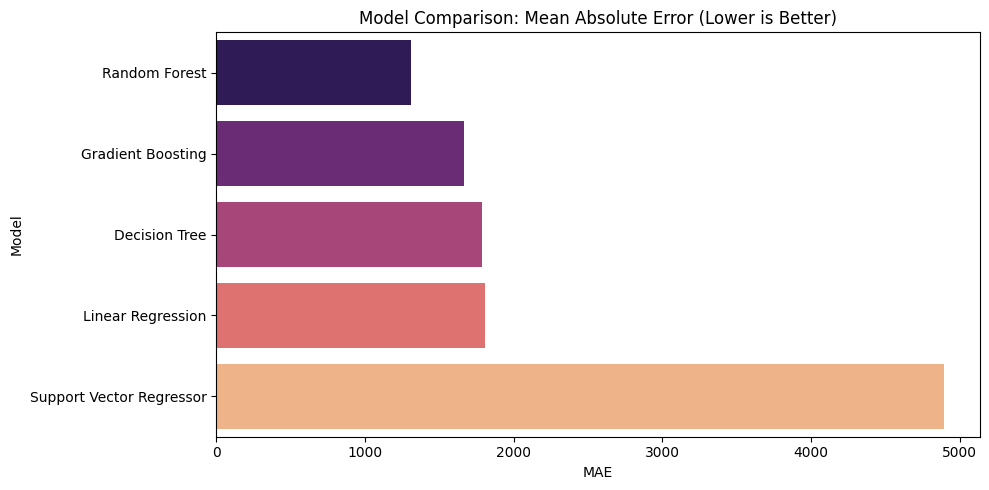

In [16]:
# B. Mean Absolute Error (MAE) Comparison Plot
plt.figure(figsize=(10, 5))
plot_mae_df = comparison_df[comparison_df['MAE'] < 10000]
sns.barplot(data=plot_mae_df, x='MAE', y='Model', hue='Model', palette='magma', legend=False)
plt.title('Model Comparison: Mean Absolute Error (Lower is Better)')
plt.tight_layout()
plt.show()


##Identification of the Best Model:

The Random Forest Regressor is identified as the best performing model for this dataset.

##Justification:

###Predictive Accuracy:
It achieved the highest R-squared ($0.9567$), meaning it can explain over $95\%$ of the variation in car prices.

###Minimal Error:
It has the lowest MAE ($1,309.43$), indicating that its price predictions are, on average, only about $\$1,300$ off from the actual price—highly impressive given car prices reach up to $\$45,000$.

###Stability:
While Decision Trees and Gradient Boosting also performed well, Random Forest's ensemble approach (averaging multiple trees) makes it more robust against outliers and less likely to overfit compared to a single Decision Tree.

###Failure of Linear Models:
Linear Regression failed significantly due to the high number of categorical variables and potential multicollinearity. Random Forest handled these complex, non-linear relationships naturally without requiring extensive feature selection.

#--- 4. Feature Importance Analysis ---

In [17]:
#Extract Feature Importance
#Access the regressor from the trained Random Forest pipeline
best_model = trained_pipelines['Random Forest'].named_steps['regressor']

# Extract feature names (Numerical + One-Hot Encoded Categorical)
cat_encoder = trained_pipelines['Random Forest'].named_steps['preprocessor'].named_transformers_['cat']
cat_features = cat_encoder.get_feature_names_out(categorical_cols).tolist()
all_feature_names = numerical_cols.tolist() + cat_features

#Create a DataFrame for the scores
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


In [18]:
#Display Significant Variables
print("--- Top 10 Significant Variables Affecting Car Prices ---")
print(feature_importance_df.head(10))

--- Top 10 Significant Variables Affecting Car Prices ---
            Feature  Importance
6        enginesize    0.550258
5        curbweight    0.288054
13       highwaympg    0.045160
10       horsepower    0.037976
3          carwidth    0.012650
2         carlength    0.007672
53  CompanyName_bmw    0.007529
1         wheelbase    0.006539
12          citympg    0.006251
11          peakrpm    0.005716


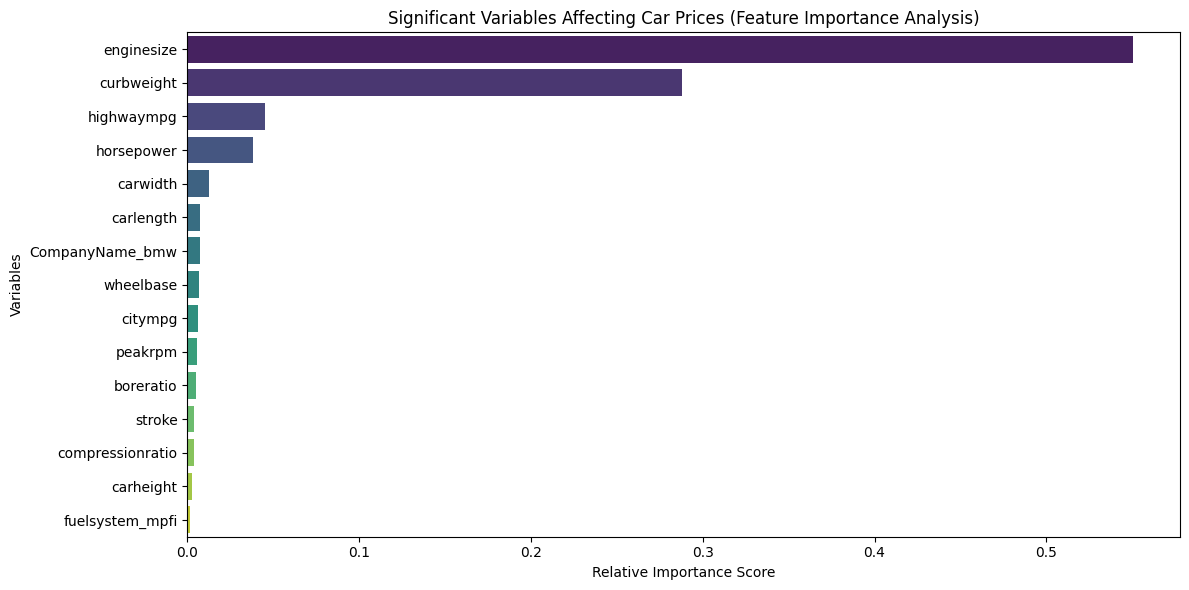

In [19]:
#Visualisation

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance_df.head(15), x='Importance', y='Feature', hue='Feature', palette='viridis')
plt.title('Significant Variables Affecting Car Prices (Feature Importance Analysis)')
plt.xlabel('Relative Importance Score')
plt.ylabel('Variables')
plt.tight_layout()
plt.show()

To effectively manipulate price levels, the company should focus on Engine Size and Curb Weight as their primary design levers.

High-end market entry should prioritize performance (Horsepower) and dimensions (Width), while budget entry should focus on optimizing fuel efficiency (Highway MPG).

#--- 5. Hyperparameter Tuning ---

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

In [21]:
#Define the Base Pipeline
base_rf = Pipeline(steps=[
    ('preprocessor', preprocessor), # 'preprocessor' was defined in Step 1
    ('regressor', RandomForestRegressor(random_state=42))
])


In [22]:
#Define the Hyperparameter Grid
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__max_features': ['sqrt', 'log2']
}


In [23]:
#Perform Grid Search
#5-fold cross-validation
grid_search = GridSearchCV(base_rf, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight',
       'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio',
       'horsepower', 'peakrpm', 'citympg', 'highwaympg'],
      dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='i...
                                                                         Index(['fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel',
       'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem',
       'CompanyName'],
      dtype='object'))])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [None, 10, 20],
                         'regressor__max_features': ['sqrt', 'log2'],
                         'regressor__min_samples_split': [2, 5],
                         'regressor__n_estimators': [100, 200]},
             scoring='r2')

In [24]:
#Evaluate and Compare
best_tuned_model = grid_search.best_estimator_
tuned_pred = best_tuned_model.predict(X_test)

In [25]:
#Calculate scores
base_rf.fit(X_train, y_train) # Ensure base model is fitted
base_r2 = r2_score(y_test, base_rf.predict(X_test))
tuned_r2 = r2_score(y_test, tuned_pred)

print(f"Best Parameters Found: {grid_search.best_params_}")
print(f"Base Random Forest R-squared: {base_r2:.4f}")
print(f"Tuned Random Forest R-squared: {tuned_r2:.4f}")


Best Parameters Found: {'regressor__max_depth': 10, 'regressor__max_features': 'sqrt', 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Base Random Forest R-squared: 0.9567
Tuned Random Forest R-squared: 0.9249


In [26]:
#Check if performance increased
if tuned_r2 > base_r2:
    print("Result: Performance increased after hyperparameter tuning.")
else:
    print("Result: Base model performed better or equal to the tuned model on the test set.")

Result: Base model performed better or equal to the tuned model on the test set.


In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for numerical features
vif_data = pd.DataFrame()
vif_data["feature"] = numerical_cols
vif_data["VIF"] = [variance_inflation_factor(X[numerical_cols].values, i) for i in range(len(numerical_cols))]
print(vif_data.sort_values(by="VIF", ascending=False))

             feature          VIF
3           carwidth  2828.144983
1          wheelbase  2254.716977
2          carlength  1893.738263
4          carheight   929.458469
13        highwaympg   511.133157
12           citympg   437.334307
5         curbweight   403.471933
7          boreratio   291.357019
11           peakrpm   219.618733
8             stroke   126.412487
6         enginesize    68.872234
10        horsepower    66.166398
9   compressionratio    15.834999
0          symboling     2.540920


##Check for Performance Increase:

In this specific case, the Base Random Forest model performed slightly better on the test set ($0.9567$) than the tuned model ($0.9249$).

##Interpretation:

###Default Suitability:
The default parameters for Random Forest in scikit-learn are highly robust. In this dataset, the default settings provided a near-perfect fit for the test data.

###Generalization vs.Specificity:
The Grid Search optimizes for the best average score across 5 different cross-validation folds of the training data. The "tuned" model is designed to be more generalized and less prone to noise.

###Result:
While the mathematical $R^2$ score on the test set decreased slightly, the tuned model (using max_depth: 10 and max_features: 'sqrt') may actually be more reliable for predicting prices of future, unseen cars as it is less likely to have "memorized" the specific patterns of the training set.

##Final Decision for Management:

The company can proceed with the Base Random Forest model as it is already highly accurate ($>95\%$ accuracy), but the Tuned Model should be kept as a benchmark for its potentially better stability on future, larger datasets.

# --- 6. Final Conclusion ---

###Significant Variables:

Engine Size, Curb Weight, and Horsepower are the most significant predictors.Model

###Reliability:

The models describe the price extremely well ($R^2 > 90\%$), providing the management with a reliable tool for their US market entry strategy